# Mueller Matrix Ellipsometry of 3D multilayers
The notebook is to simulate Mueller Matrix Ellipsometry of a 3D multilayer structures. The bottom-up approach is used to simulate only a quarter of global scattering matrix to quantify the reflected coefficents of both TE and TM polarizations,enabling efficient simulation of the Mueller Matrix.

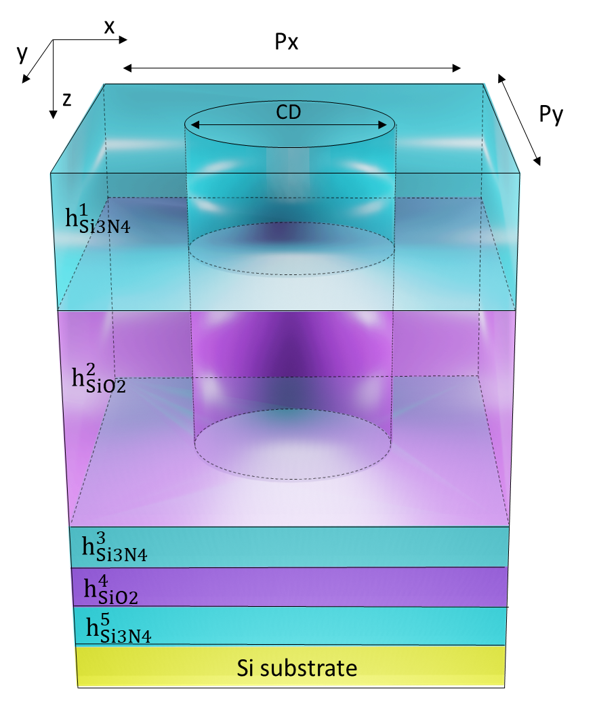

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import sys
path_parent=os.path.dirname(os.getcwd())
sys.path.insert(0,path_parent)

from src import ReadData
from src import rcwa
from src import Mueller
from src.DispersionModel import Tauc_Lorentz

path_image=path_parent +"/image/Odiff.png"
from IPython.display import Image
Image(filename=path_image,width=250)

## 1. Optical index: 

Make sure that eps have negative sign: eps=eps1-1j*eps2

In [2]:
# 1. read from database
path_optical_index=path_parent+'/dataNK/'
path_Si=path_optical_index+ 'c-Si_HJY_Modif.txt'
path_SiO2=path_optical_index+ 'SiO2_HJY_Modif.txt'

h=4.135667516*1e-15;#[eV s]      
c=299792458         #[m/s]

Si_wl, Si_nk=ReadData.read_nk(path_Si)
Si_wl=h*c/Si_wl*10**9      #eV to nm

SiO2_wl, SiO2_nk=ReadData.read_nk(path_SiO2)
SiO2_wl=h*c/SiO2_wl*10**9  #eV to nm

# 2.Interpolate
wavelength_range=np.linspace(550,900,71) 
e_Si,e_SiO2=ReadData.interpolate(wavelength_range,[Si_wl, Si_nk],[SiO2_wl, SiO2_nk])

# Tauc_Lorentz for SiN
E_eV=h*c/wavelength_range*10**9
parameter=[ 4.25173271,   1.63576659, 104.27127241,   8.21648003,  3.38110812 ]# 5layers (Eg,e_inf,A,E0,C)
e_Si3N4=Tauc_Lorentz(E_eV,parameter)

#reflectance and transmittance zone
e_trn=np.copy(e_Si);  
e_ref=1 # air

## 2. Input parameters

In [3]:
sim=rcwa()
sim.setup(wavelength_range=wavelength_range,
        LxLy=[470,470],              # periodic length [Lx,Ly]
        NxNy=[470,470],              # simulation domain [Nx,Ny]
        order=[5,5],                 # diffraction order [mx,my]
        angle=[65,45],               # [AOI_d,Azimuth_d] in degree             
        e_ref=e_ref,                 # reflected medium
        e_trn=e_trn,                 # transmitted medium                   
            )

## 3. Geometry: user define

In [4]:
eps=[e_Si3N4,e_SiO2,e_Si3N4,e_SiO2,e_Si3N4] 
eps_name=['Si3N4','SiO2','Si3N4','SiO2','Si3N4']
h=[50,660,50,80,22]
Diameter=120

Structure=[]
NL=len(eps)
for lth in range(NL):
    layer=sim.Geometry.layer()     
    if lth <2:
        mask=sim.Geometry.Circle(D=Diameter) 
        layer['medium']={'eps':eps[lth],'h':h[lth],'eps_name':eps_name[lth]}
        layer['pattern']={'eps':e_ref, 'mask':mask,'eps_name':'air'}   
    else:
        layer['medium']={'eps':eps[lth],'eps_name':eps_name[lth],'h':h[lth]}  
    Structure.append(layer)  

C:\Users\hpham\Desktop\RCWA_numpy\src\Geometry.py:13: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


## 4. Visualization

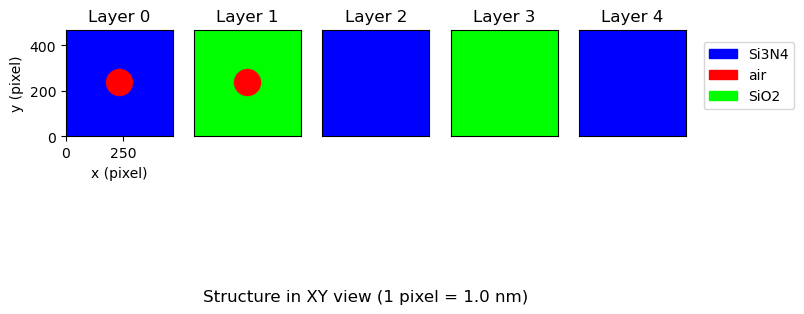

In [5]:
sim.Plot.XY(Structure,layer_position=[0,1,2,3,4])

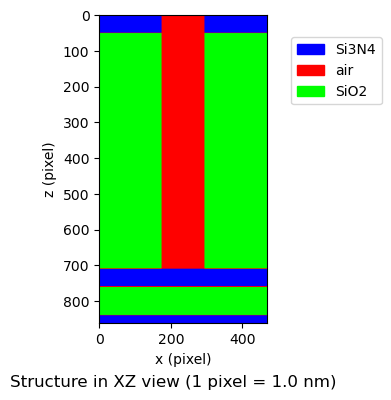

In [6]:
sim.Plot.XZ(Structure)

##  5. Simulation

### 5.1 Conventional

In [7]:
t0=time.time()
Coeff=[]
for wth in range(len(wavelength_range)): 
    
    #Scattering matrix    
    S_layer=sim.S_layer(Structure,idx=wth)    
    S_global=sim.S_System(S_layer,S_Ref=False)    # the reflected medium is air
    
    # coefficients
    S_global_11=S_global[0];   
    order =sim.Nharm//2
    
    sim.SourcePlaneWave(mode='TE')
    rxS,ryS= sim.coeff(S_global_11)  
    
    sim.SourcePlaneWave(mode='TM')
    rxP,ryP= sim.coeff(S_global_11)  

    Coeff.append([rxP[order],ryP[order],rxS[order],ryS[order]])

Coeff=np.stack(Coeff)   
Coeff=Coeff.transpose(1,0)    # shape: 4 x wl     
rpp,rps,rsp,rss=sim.Rotate_SP(Coeff) #rotate AOI, azimuth

m11,m12,m33,m34=Mueller.matrix_4(rpp,rps,rsp,rss)
m12=m12/m11
m33=m33/m11
m34=m34/m11    
#print(time.time() -t0)    

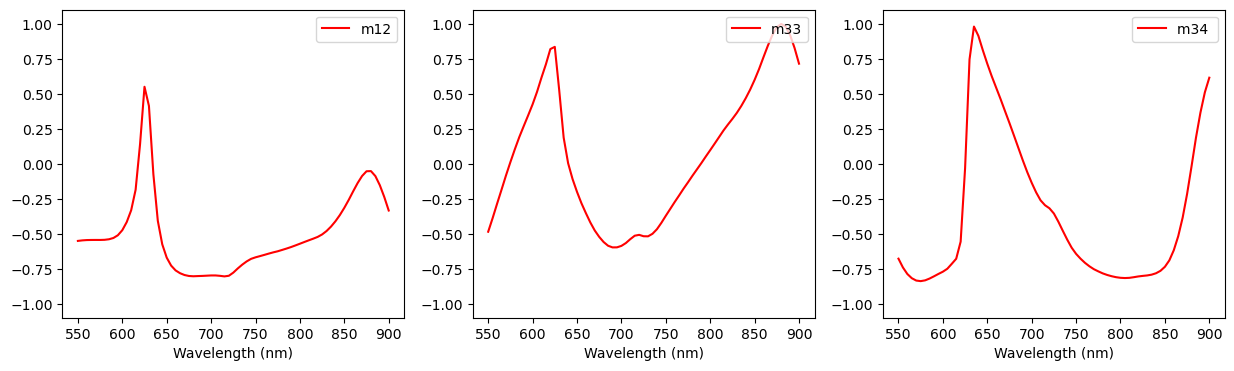

In [8]:
fig_size=(15,4)
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3,figsize=fig_size)

ax1.plot(wavelength_range,m12,c='red')
ax1.legend(['m12'],loc='upper right')
ax1.set_xlabel('Wavelength (nm)') 
ax1.set_ylim([-1.1, 1.1])

ax2.plot(wavelength_range,m33,c='red')
ax2.legend(['m33'],loc='upper right')
ax2.set_xlabel('Wavelength (nm)') 
ax2.set_ylim([-1.1, 1.1])

ax3.plot(wavelength_range,m34,c='red')
ax3.legend(['m34 '],loc='upper right')
ax3.set_xlabel('Wavelength (nm)') 
ax3.set_ylim([-1.1, 1.1])

plt.show()

###  5.3 Bottom-up: 

In the bottom-up approach, the parameter `only_R` is set to `False` by default, simulating half of the global scattering matrix for full optical responses. For applications focused on reflected waves, the bottom-up approach can simulate only a quarter of the global scattering matrix. To do this, set the parameter `only_R=True` as follows:
```python
S_global=sim.S_System_bottom_up(S_layer,nb=3,only_R=True)
```
where `S_layer` is a list of scattering matrices of component layers in the structure and `nb` is the number of homogeneous bottom layers   


In [9]:
t0=time.time()
Coeff=[];  
for wth in range(len(wavelength_range)):  
    
    S_layer=sim.S_layer(Structure,idx=wth,form='vector')  
    S_global=sim.S_System_bottom_up(S_layer,nb=3,only_R=True,S_Ref=False)  # nb: number of homogeneous bottom layers
    
   # coefficients
    S_global_11=S_global[0];   
    order =sim.Nharm//2
    
    sim.SourcePlaneWave(mode='TE')
    rxS,ryS= sim.coeff(S_global_11)  
    
    sim.SourcePlaneWave(mode='TM')
    rxP,ryP= sim.coeff(S_global_11)  

    Coeff.append([rxP[order],ryP[order],rxS[order],ryS[order]])

Coeff=np.stack(Coeff)   
Coeff=Coeff.transpose(1,0)    # shape: 4 x wl     
rpp,rps,rsp,rss=sim.Rotate_SP(Coeff) #rotate AOI, azimuth

m11,m12,m33,m34=Mueller.matrix_4(rpp,rps,rsp,rss)
m12=m12/m11
m33=m33/m11
m34=m34/m11    
#print(time.time() -t0)  

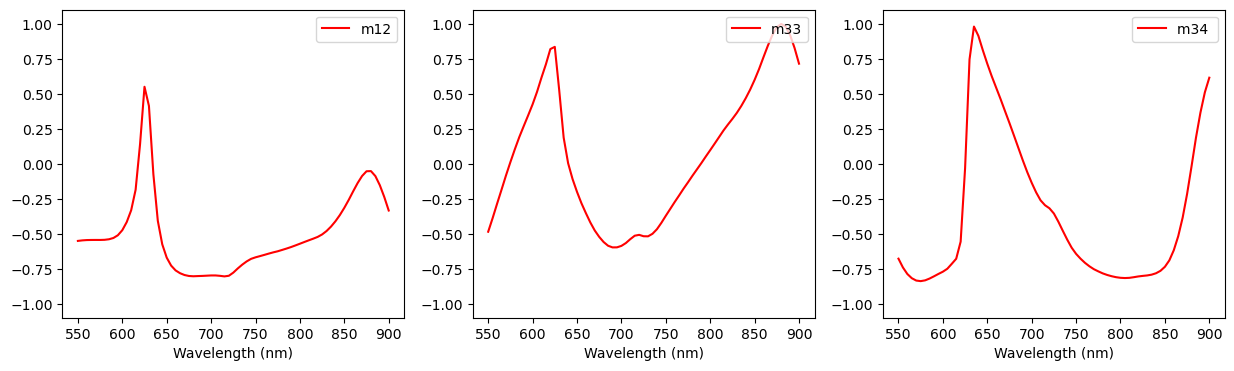

In [10]:
fig_size=(15,4)
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3,figsize=fig_size)

ax1.plot(wavelength_range,m12,c='red')
ax1.legend(['m12'],loc='upper right')
ax1.set_xlabel('Wavelength (nm)') 
ax1.set_ylim([-1.1, 1.1])

ax2.plot(wavelength_range,m33,c='red')
ax2.legend(['m33'],loc='upper right')
ax2.set_xlabel('Wavelength (nm)') 
ax2.set_ylim([-1.1, 1.1])

ax3.plot(wavelength_range,m34,c='red')
ax3.legend(['m34 '],loc='upper right')
ax3.set_xlabel('Wavelength (nm)') 
ax3.set_ylim([-1.1, 1.1])

plt.show()